In [146]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler


from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import (r2_score, mean_squared_error, plot_confusion_matrix)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import pickle

%matplotlib inline


## Cargamos nuestro dataset

In [48]:
df = pd.read_csv('data/data.csv')

In [52]:
df.shape[0], df.shape[1]

(19079, 50)

## Análisis exploratorio y limpieza

In [69]:
df.drop("cla_colada", axis=1, inplace=True)

In [53]:
#eliminamos las columnas donde la suma es 0, ya que hay chatarras que jamnás se usan
# de 50 columnas, pasamos a 27
l = list(df.columns.values)
for l in l:
    if sum(df[l]) == 0:
        df.drop(l, axis=1, inplace=True)        
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19079 entries, 0 to 19078
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cla_horno           19079 non-null  int64  
 1   cla_colada          19079 non-null  int64  
 2   cla_grado_obtenido  19079 non-null  int64  
 3   Mw_PowerOn          19079 non-null  float64
 4   tco_tcm             19079 non-null  float64
 5   CH01                19079 non-null  int64  
 6   CH02                19079 non-null  int64  
 7   CH03                19079 non-null  int64  
 8   CH04                19079 non-null  int64  
 9   CH05                19079 non-null  int64  
 10  CH06                19079 non-null  int64  
 11  CH07                19079 non-null  int64  
 12  CH08                19079 non-null  int64  
 13  CH09                19079 non-null  int64  
 14  CH10                19079 non-null  int64  
 15  CH12                19079 non-null  int64  
 16  CH15

In [70]:
df.shape[0], df.shape[1];
df.head(3)

,cla_horno,cla_grado_obtenido,Mw_PowerOn,tco_tcm,CH01,CH02,CH03,CH04,CH05,CH06,...,CH31,CH33,CH34,CH50,CH60,CH63,CH64,CH66,CH70,CH71
0,3,2217,189.0,148.692993,5570,15425,12346,5258,0,7233,...,0,0,3619,4055,3342,0,4713,0,0,0
1,3,2217,190.0,148.339004,6700,16203,13552,2538,0,6840,...,0,0,4250,3807,2794,0,3961,0,0,0
2,3,2217,190.0,148.455994,6131,15125,12525,4936,0,7092,...,0,0,4207,2932,3009,0,5273,0,0,0


In [71]:
#comprobamos que el dataset no contiene nulos
df.isna().sum()

cla_horno             0
cla_grado_obtenido    0
Mw_PowerOn            0
tco_tcm               0
CH01                  0
CH02                  0
CH03                  0
CH04                  0
CH05                  0
CH06                  0
CH07                  0
CH08                  0
CH09                  0
CH10                  0
CH12                  0
CH15                  0
CH31                  0
CH33                  0
CH34                  0
CH50                  0
CH60                  0
CH63                  0
CH64                  0
CH66                  0
CH70                  0
CH71                  0
dtype: int64

<AxesSubplot:>

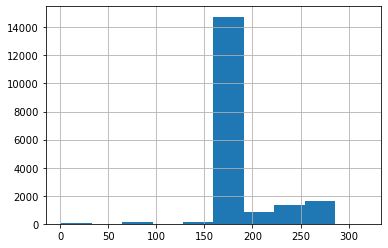

In [63]:
df.Mw_PowerOn.hist()

In [64]:
df = df[df['Mw_PowerOn'] > 50 ]

<AxesSubplot:>

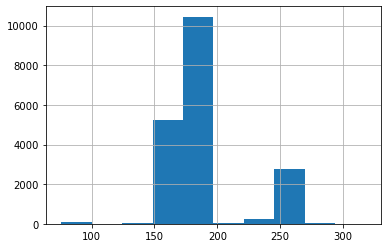

In [65]:
df.Mw_PowerOn.hist()

In [72]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cla_horno,18866.0,2.475034,0.499390,2.000000,2.000000,2.000000,3.000000,3.000000
cla_grado_obtenido,18866.0,1869.566363,785.393816,0.000000,2019.000000,2217.000000,2308.000000,2479.000000
Mw_PowerOn,18866.0,190.849308,29.818190,76.000000,171.602500,185.000000,190.000000,317.810000
tco_tcm,18866.0,137.676668,10.647946,48.200001,128.199997,132.199997,148.552994,162.800003
CH01,18866.0,9073.214142,3419.292165,0.000000,7543.000000,9907.000000,10600.000000,46148.000000
CH02,18866.0,27545.071716,30002.899374,0.000000,0.000000,17800.000000,49300.000000,129800.000000
CH03,18866.0,17874.409096,11929.777136,0.000000,6400.000000,19100.000000,26100.750000,72880.000000
CH04,18866.0,7851.046486,8646.700745,0.000000,0.000000,5600.000000,10550.000000,66800.000000
CH05,18866.0,82.213347,837.972900,0.000000,0.000000,0.000000,0.000000,15000.000000
CH06,18866.0,6023.750769,3327.359090,0.000000,4033.000000,6100.000000,8100.000000,54158.000000


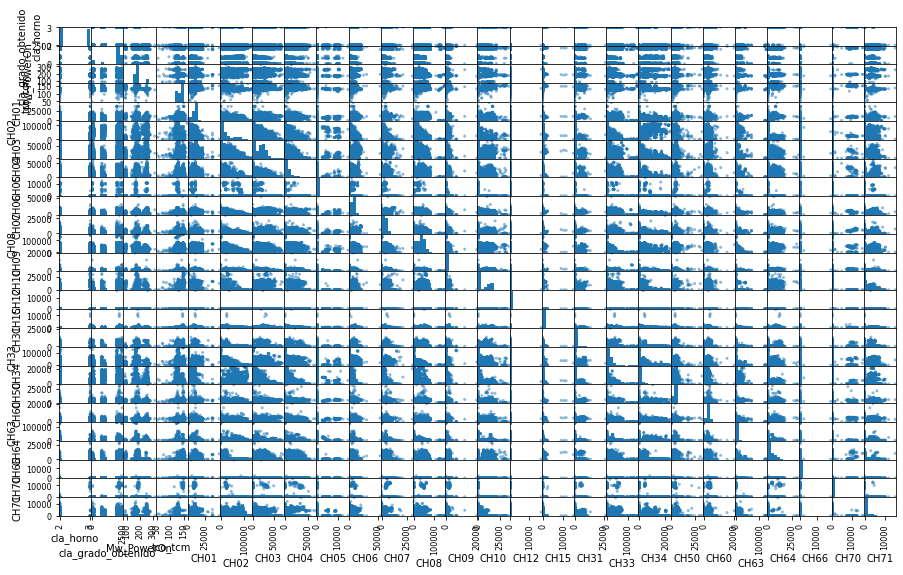

In [80]:
scatter_matrix(df, figsize=(15,9));
#pd.plotting.scatter_matrix(df[['Mw_PowerOn','cla_grado_obtenido','tco_tcm','cla_horno']],alpha=0.4,figsize=(15,15));


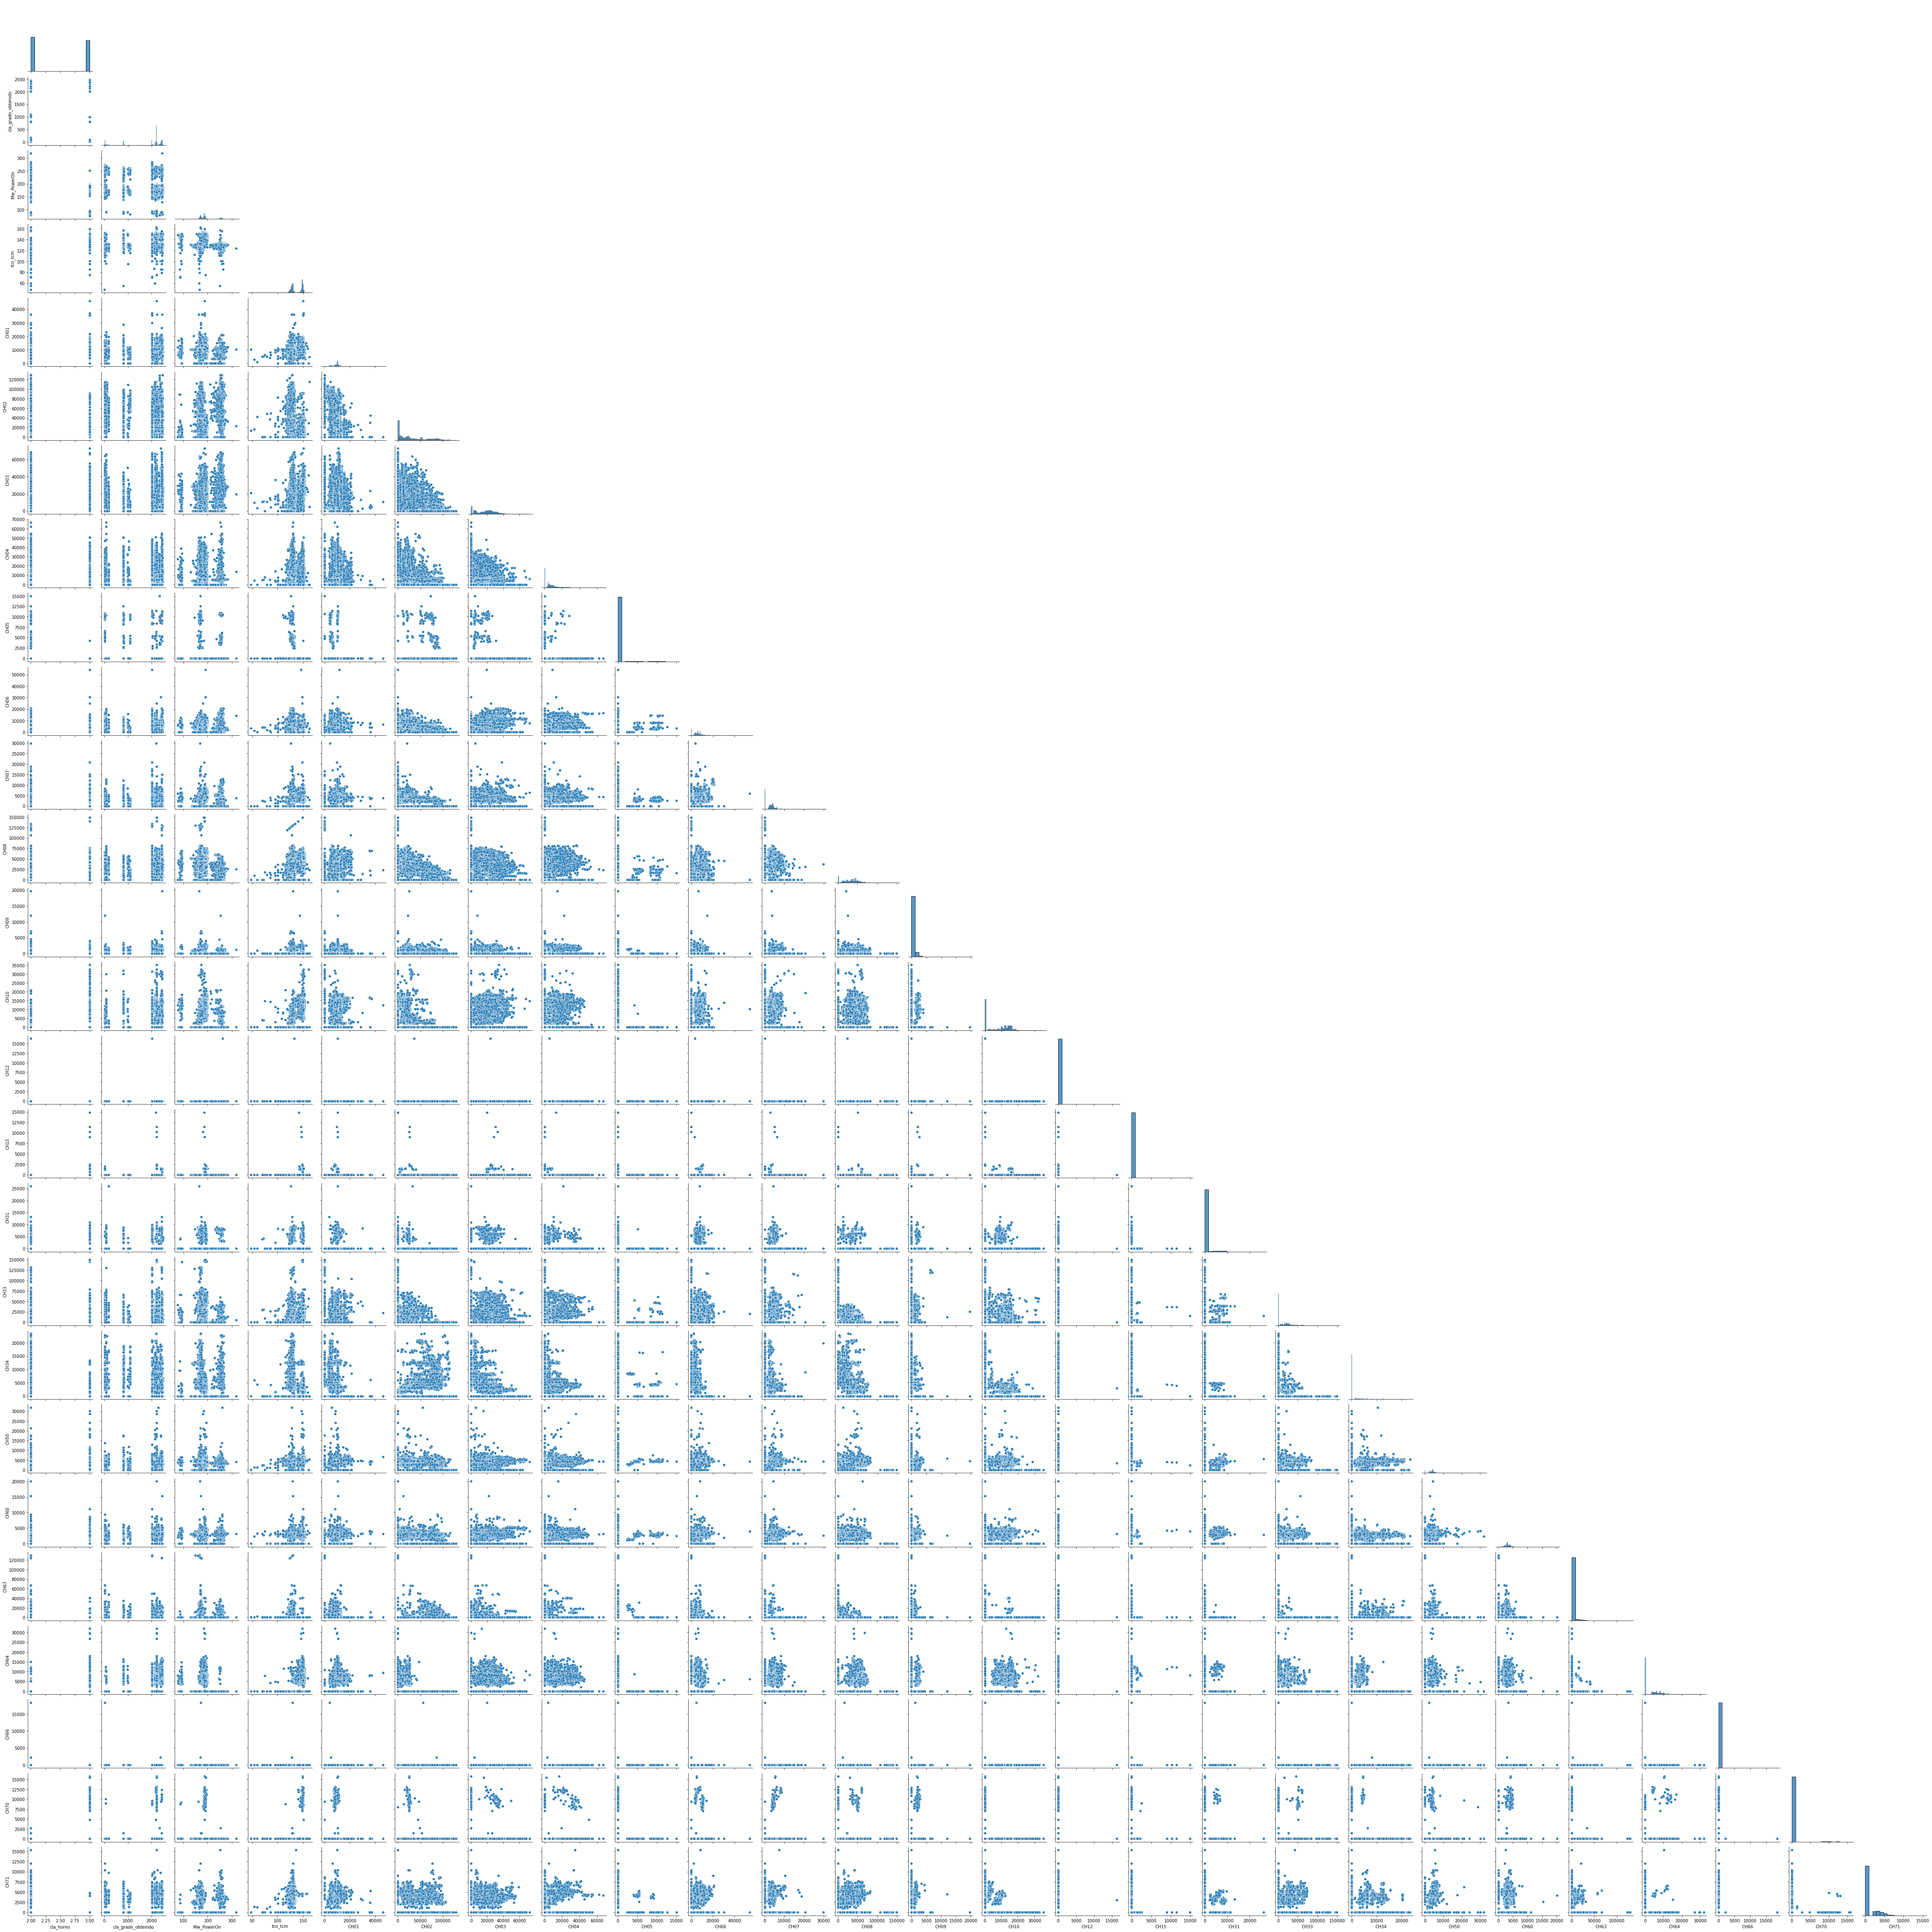

In [79]:
sns.pairplot(df, corner=True);
#sns.pairplot(df[['Mw_PowerOn','cla_grado_obtenido','tco_tcm','cla_horno']])

## Definimos nuestro target y features

In [81]:
y = df["Mw_PowerOn"]
X = df.drop("Mw_PowerOn", axis=1)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

## Modelo baseline

In [83]:
pd.Series(y_train).value_counts(normalize=True)

187.00    0.054826
188.00    0.048576
186.00    0.048022
189.00    0.042563
185.00    0.040585
            ...   
161.47    0.000079
180.66    0.000079
250.99    0.000079
181.05    0.000079
161.90    0.000079
Name: Mw_PowerOn, Length: 2904, dtype: float64

In [85]:
mean_squared_error(y_train, np.zeros(y_train.size))

37293.09162768196

In [90]:
dc = DummyRegressor().fit(X_train, y_train)
yhat_dc = dc.predict(X_train)

In [92]:
mean_squared_error(y_train, yhat_dc), r2_score(y_train, yhat_dc)

(891.6815705928781, 0.0)

## Probamos los modelos más comunes

In [95]:
models = [KNeighborsRegressor, LinearRegression, Lasso, Ridge, ElasticNet, DecisionTreeRegressor, RandomForestRegressor, XGBRegressor]

In [96]:

scores = np.zeros(len(models))
for i, Model in enumerate(models):
    model = Model().fit(X_train, y_train)
    y_hat = model.predict(X_test)
    score = mean_squared_error(y_test, y_hat)
    print("Modelo: ", type(model).__name__, " MSE: ", score)
    scores[i] = score

Modelo:  KNeighborsRegressor  MSE:  242.81382748217152
Modelo:  LinearRegression  MSE:  705.6468377553123
Modelo:  Lasso  MSE:  710.9174648734938
Modelo:  Ridge  MSE:  705.6389430172525
Modelo:  ElasticNet  MSE:  710.9163183689316
Modelo:  DecisionTreeRegressor  MSE:  356.88515711532284
Modelo:  RandomForestRegressor  MSE:  174.35018523881317
Modelo:  XGBRegressor  MSE:  191.1546859992933


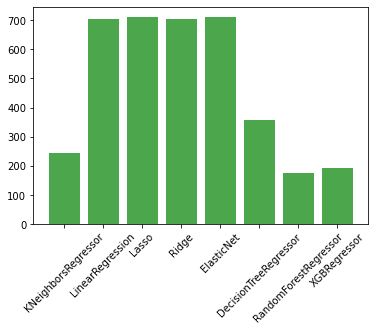

In [98]:
plt.bar([m.__name__ for m in models], scores, color='green', alpha=0.7)
plt.axhline(y=0.63, linewidth=1, color='k')
plt.xticks(rotation=45);

### GridSearch

In [103]:
def gs_best(params, model):
    model2 = model()
    gs = GridSearchCV(model2, params, cv=5, n_jobs=-1, verbose=1)    
    gs.fit(X_train, y_train)
    best = model(**gs.best_params_).fit(X_train, y_train)
    y_hat=best.predict(X_test)
    r2=r2_score(y_test, y_hat)
    m2 = mean_squared_error(y_test, y_hat)    
    return best, r2, m2

In [102]:
models = [DecisionTreeRegressor,
          RandomForestRegressor,
          XGBRegressor]
params = [{},
          {},
          {'max_depth':[3,6,10],'learning_rate':[0.01,0.05,0.1],'eta':np.logspace(-1,0,10)}
         ]
names = ["DecisionTreeRegressor",
          "RandomForestRegressor",
          "XGBRegressor"]

for model, param, name in zip(models, params, names):
    (model, r2_result, mse_result) = gs_best(param, model)
    print(name," r2: ",r2_result, " mse: ",mse_result)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
DecisionTreeRegressor  r2:  0.5901498457137746  m2:  362.2131487793125
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RandomForestRegressor  r2:  0.8038401511071399  m2:  173.36013122966136
Fitting 5 folds for each of 90 candidates, totalling 450 fits
XGBRegressor  r2:  0.8026073333130526  m2:  174.4496582443461


## Modelo final

In [105]:
(model_, r2_result, mse_result) = gs_best({}, RandomForestRegressor)
y_hat = model_.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [106]:
y_hat

array([167.1337, 168.7583, 182.21  , ..., 186.69  , 242.6709, 180.35  ])

In [119]:
df_predicciones = pd.DataFrame.copy(X_test)
df_predicciones["target"] = y_test
df_predicciones["prediccion"]=y_hat

,cla_horno,cla_grado_obtenido,tco_tcm,CH01,CH02,CH03,CH04,CH05,CH06,CH07,...,CH34,CH50,CH60,CH63,CH64,CH66,CH70,CH71,target,prediccion
12253,2,2414,123.099998,6400,67400,5800,0,0,4500,2200,...,0,5800,3400,0,0,0,0,4600,167.89,167.1337
10420,2,2027,128.300003,6200,69600,4500,0,0,2400,2200,...,12400,4100,2300,0,0,0,0,0,170.13,168.7583
5199,3,2217,150.893005,11082,0,22284,11814,0,9844,4075,...,0,4731,4316,0,9747,0,0,0,185.00,182.2100


In [121]:
df_predicciones["comparacion"] = abs(df_predicciones["target"] - df_predicciones["prediccion"])
df_predicciones.head(3)

,cla_horno,cla_grado_obtenido,tco_tcm,CH01,CH02,CH03,CH04,CH05,CH06,CH07,...,CH50,CH60,CH63,CH64,CH66,CH70,CH71,target,prediccion,comparacion
12253,2,2414,123.099998,6400,67400,5800,0,0,4500,2200,...,5800,3400,0,0,0,0,4600,167.89,167.1337,0.7563
10420,2,2027,128.300003,6200,69600,4500,0,0,2400,2200,...,4100,2300,0,0,0,0,0,170.13,168.7583,1.3717
5199,3,2217,150.893005,11082,0,22284,11814,0,9844,4075,...,4731,4316,0,9747,0,0,0,185.00,182.2100,2.7900


In [122]:
df_predicciones["comparacion"].describe()

count    6226.000000
mean        6.310274
std        11.475030
min         0.000000
25%         1.282575
50%         2.860000
75%         5.648300
max       110.020000
Name: comparacion, dtype: float64

## Evaluar modelo final

In [123]:
model_.score(X_test, y_test)

0.8059735139415306

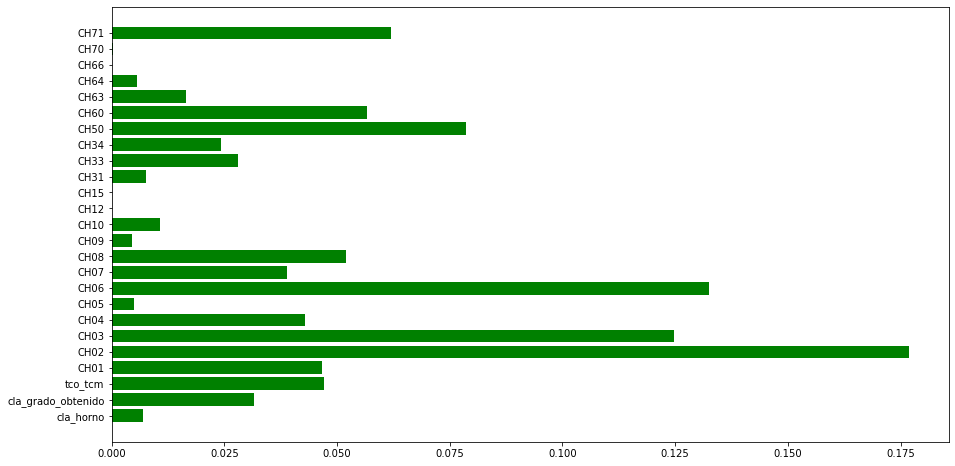

In [132]:
plt.figure(figsize=(15,8))
plt.barh(X_test.columns, model_.feature_importances_, color='green');

## Exportar modelo

In [137]:
with open('PredictMWNominacion.p', 'wb') as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [138]:
with open('PredictMWNominacion.p', 'rb') as f:
    reanimated = pickle.load(f)

In [142]:
model_.score(X_test, y_test)

0.8059735139415306